# Practicing and Testing on the .json File

This Jupyter Notebook is the first one that I started to write to analyze the .json file with all of the hits. This was mostly written with the goal of understanding the structure of the data file and trying to figure out where I could even start with the analysis. It is not exactly used in the ARTISTIC pipeline but it was needed to be able to begin to design and write this pipeline.

Start by importing the right packages. The versions are all listed in the README.md file.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate

from astropy.time import Time
from tqdm import tqdm

First start by loading in the data file with all of the hits. These observations were taken during the third epoch of the Very Large Array Sky Survey (VLASS). They were then run through COSMIC and SETICore, which then gives many hits. These hits are mostly likely RFI. But the whole point of this analysis is to start sorting out this RFI and find any anomalies that might need to be investigated further. I need to be able to figure out what is happening inside of the data file first.

In [2]:
df = pd.read_json('../../Preliminary_Data_Files/hits_collation.json')

When opening up the file, the first thing that I wanted to look at was the shape of the data file. It has a shape of (5,697,746 x 24). I'll then start by defining the parameters to look at more of the data. Then examine some of the data, row by row, just to understand what it looks like.

In [87]:
#Define the right ascension and the declination. We should be pointing near the galactice center for these observations.
ra = df["ra"]
dec = df["dec"]

#Print out one of the rows of the dataframe
display(df.iloc[3])

######### Now let's just look at the different beams of the first field of view #########
beam = np.array(df.iloc[:180]["beam"]).tolist()
freq = np.array(df.iloc[:180]["signal_frequency"]).tolist()
power = np.array(df.iloc[:180]["signal_power"]).tolist()

#Print out the number of hits per beam for the first 180 rows
print(np.array(beam).tolist().count(0), np.array(beam).tolist().count(1), np.array(beam).tolist().count(2), 
      np.array(beam).tolist().count(3), np.array(beam).tolist().count(4), np.array(beam).tolist().count(5))

#Define the start times of one the observations
Tstart = np.array(df["tstart"])
print(np.max(Tsamp), np.min(Tsamp), len(np.unique(Tsamp).tolist()))

#Recall that there are 5 coherent beams (0-4) and one incoherent beam (5)

file_path                 /mnt/cosmic-storage-1/data2/vlass_target/VLASS...
hit_file_enumeration                                                      3
signal_frequency                                                2861.153702
signal_index                                                          20146
signal_driftSteps                                                         0
signal_driftRate                                                        0.0
signal_snr                                                       131.106888
signal_coarseChannel                                                      0
signal_numTimesteps                                                      64
signal_power                                                  2118776389632
signal_incoherentPower                                        2193388339200
sourceName                                                11561369061801728
fch1                                                            2861.153397
foff        

29 31 30 30 31 29
60006.31329548964 60006.076254917774 1721


Now set up a small table using tabulate to examine the beam, frequency, and power. As I was doing this, I learned that there are a few ways that I can do this. One is to just make a dictionary and then use the tabulate package to put together this table. This works decently well, but another way to show this, which I think is probably more common and easier is to use a pandas dataframe. But here, I show both ways of doing that. This is mainly just because at first I was doing everything in tabulate tables, and then later switched everything to pandas dataframes.

This data comes from one of the first cells where I looked at just the first 180 rows for the beam, frequency, and the power. So it doesn't really mean much, it is just me learning.

In [88]:
#Define the dictionary that will organize the information that I want into a table.
info = {'Beam Number': np.array(beam).tolist()[0:8], 
        'Frequency': np.array(freq).tolist()[0:8], 
        'Power': np.array(power).tolist()[0:8]}

pandas_data_frame = pd.DataFrame({'Beam Number': np.array(beam).tolist()[0:8], 
                                  'Frequency': np.array(freq).tolist()[0:8], 
                                  'Power': np.array(power).tolist()[0:8]})

source_name = np.array(field_of_view_1["sourceName"])
print(np.unique(source_name))

print(tabulate(info, headers = 'keys'))
display(pandas_data_frame)

['16384823493538944' '16386369681765120' '16433923559663616'
 '16434640818646528' '16434851272560768' 'Incoherent']
  Beam Number    Frequency          Power
-------------  -----------  -------------
            0      2861.13   230584975360
            0      2861.42   548371169280
            4      2861.13   239149121536
            4      2861.15  2118776389632
            3      2861.38  1845228208128
            3      2861.39   208835641344
            3      2861.4   1176264245248
            3      2861.42   529518264320


,Beam Number,Frequency,Power
0,0,2861.129906,230584975360
1,0,2861.424904,548371169280
2,4,2861.129906,239149121536
3,4,2861.153702,2118776389632
4,3,2861.379898,1845228208128
5,3,2861.386749,208835641344
6,3,2861.402298,1176264245248
7,3,2861.424896,529518264320


So I started out by just looking at some of the data above. I also haven't worked with data frames or tables like this before, so a lot of this notebook is also just learning how to call in specific lines or values from the table.

Here I am going to start by seeing how many fields of view, coordinates, and sources there are in this file. Also not that you should avoid doing things with the full data frame, because it is so big that it takes a while to load.

In [73]:
######### Looking at the number of hits in each field of view #########
file_path = df["file_path"]
unique_file_path = np.unique(file_path) #the array of unique fields of view

print(len(np.unique(df.iloc[:]["ra"])), len(np.unique(df.iloc[:]["dec"])))

print(np.count_nonzero(file_path == unique_file_path[2]))
print(file_path.tolist().count(file_path[23330]))

7295 7418
515
290


Now I am interested in seeing the different ways that I can examine the start times (tstart). This will be useful in looking at the drift rates later on. All of the times are listed in MJD (Modified Julian Date) with the observations all taking place on March 3, 2023. So using astropy, I am looking to see some of the time differences to see the maximum time separations between two observations of the same source. 

In [76]:
signal_index = np.array(df["signal_index"]).tolist() 
#The signal index tells something about the number within a field of view or something like that. But because they only go up to
#101051, then some of them must repeat

tstart = np.array(df["tstart"]) #Define the start times within the full data set
source = np.array(df["sourceName"]) #Define the unique stars (Gaia Catalogue)

#I pulled a few random hits to look at their start times. But they aren't from the same source so it's just a check for the math
print(tstart[signal_index.index(39691)], tstart[signal_index.index(55130)])
print(source[signal_index.index(39691)], source[signal_index.index(55130)])

times = [tstart[signal_index.index(39691)], tstart[signal_index.index(55130)]] #put the times into a list
diff_times = tstart[signal_index.index(66119)] - tstart[signal_index.index(62547)] 
#find the difference between the times for two hits

difference = diff_times*24*60*60 #convert the time difference to seconds
print(difference, 'seconds')
t = Time(times, format = 'mjd') #use astropy to convert the times to date and time 
print(t.iso)

60006.07917389134 60006.07654618891
11423277273284480 11421451911507840
-264.08394277095795 seconds
['2023-03-03 01:54:00.624' '2023-03-03 01:50:13.591']


In [77]:
print(np.unique(file_path)[1]) #Look at the structure of the file path to see how they differ from each other

/mnt/cosmic-storage-1/data2/vlass_target/VLASS3.1.sb43447372.eb43676942.60006.055100046295/VLASS3.1.sb43447372.eb43676942.60006.055100046295.101.1/VLASS3.1.sb43447372.eb43676942.60006.055100046295.101.1.AC.C512.0001.seticore.hits


I made a smaller pickle file that only has the hits for a single field of view. This one is called fov_1.pkl. The first thing that I want to do with it is to figure out how to remove all of the hits that showed up in all six of the beams. So here is me trying to figure out how to do that before I start implementing it into the whole data set.

In [25]:
subset = df.loc[df['file_path'] == np.unique(file_path)[0]]

with open('../../Pickle_Files/fov_1.pkl', 'wb') as f:  # open a text file
    pickle.dump(subset, f) # serialize the list
f.close()

In [89]:
with open('../../Pickle_Files/fov_1.pkl', 'rb') as f:

    field_of_view_1 = pickle.load(f) # deserialize using load()

freq_fov_1 = field_of_view_1["signal_frequency"] #define just the column for frequencies
power_fov_1 = field_of_view_1["signal_power"] #define just the column for power
unique_freq_fov_1 = np.unique(freq_fov_1) #find the array of unique frequencies

#Here we want to find how many hits each frequency had between the 5 coherent beams and the one incoherent beam
hits_per_freq = [] #Define an empty list

for i in range(len(unique_freq_fov_1)):
    hits_per_freq.append(np.count_nonzero(freq_fov_1 == unique_freq_fov_1[i])) 
    #count the number of hits for each unique frequency and append them to the list

#Define a dictionary to line these values up    
hits_in_unique_freqs = {'Unique Frequencies': unique_freq_fov_1, 
                        'Hits per Frequency': hits_per_freq}

#Each frequency should have a maximum of 6 hits if it is widespread RFI
indices = np.where(np.array(hits_per_freq) < 6) #Find all of the indices where the number of hits per frequency is less than 6

values_less_than_6 = np.array(unique_freq_fov_1)[indices] #And then use those indices to take just the list of the ones less than 6

Once the indices to keep are found, then just take the indices that were found in the previous cell. Be sure to organize the rows by the signal frequency and then by the beam so that it is in an order where nothing is missed. This is especially because the original indexing was found by grouping up the hits based on the indices.

In [90]:
new_indices = np.where(np.isin(np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["signal_frequency"]), 
                      values_less_than_6) == True)
print(new_indices)

(array([ 84,  85,  86,  87,  94,  95, 144, 145, 146, 147, 148, 281, 282,
       283, 284, 291, 292, 341, 342, 343, 344, 345, 412, 413, 420, 421,
       422, 423, 436, 437, 438, 439, 440, 453, 454, 455, 456, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469]),)


Now taking the data from the first field of view. I organized all of that information by the signal frequency and then by the beam number. Then I included only the indices of the hits that were present in fewer than 6 of the beams. I include several of the columns from the original data set, but later, I will just have it append the entire rows from the original data set. I also started out by printing out the hits per frequency list so that I can see better by how much just this first cut trimmed things down.

In [91]:
print(hits_per_freq)

info = pd.DataFrame({'Beam Number': np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["beam"])[new_indices], 
        'Frequency': np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["signal_frequency"])[new_indices], 
        'Power': np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["signal_snr"])[new_indices], 
       'Drift Rate': np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["signal_driftRate"])[new_indices],
       'Source Name': np.array(field_of_view_1.sort_values(by = ["signal_frequency", "beam"])["sourceName"])[new_indices]})

display(info)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 4, 6, 6, 2, 3, 6, 6, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 6]


,Beam Number,Frequency,Power,Drift Rate,Source Name
0,0,2477.302750,10.477194,0.000000,16434851272560768
1,1,2477.302750,8.009394,0.000000,16434640818646528
2,3,2477.302750,9.279579,0.000000,16386369681765120
3,5,2477.302750,9.077960,0.000000,Incoherent
4,3,2477.346901,8.711601,0.000000,16386369681765120
5,5,2477.346901,8.049076,0.000000,Incoherent
6,1,2477.445648,8.340948,0.000000,16434640818646528
7,2,2477.445648,11.084569,0.000000,16384823493538944
8,3,2477.445648,11.277984,0.000000,16386369681765120
9,4,2477.445648,11.666003,0.000000,16433923559663616


Notice how in the previous cell, the source name for all of the beam 5 hit is "Incoherent". This is because that is showing the approximate location, power, signal to noise ratio, and all of the other stuff for the incoherent beams where a hit was detected. Below, I looked at how often each of the beams detected a hit. Now what is interesting is that the incoherent beam is showing about the same number of hits as each of the coherent beams. That probably shouldn't be happening because many of the hits were not detected in all of the beams. So there are plenty of hits that were detected in several coherent beams, but not the incoherent beam. This will be something to look into further later, especially with the signal to noise ratio because the incoherent beam is made by averaging out the entire field of view.

In [61]:
beam = field_of_view_1["beam"]
print('Coherent beam 1 ', np.array(beam).tolist().count(0))
print('Coherent beam 2 ', np.array(beam).tolist().count(1))
print('Coherent beam 3 ', np.array(beam).tolist().count(2))
print('Coherent beam 4 ', np.array(beam).tolist().count(3))
print('Coherent beam 5 ', np.array(beam).tolist().count(4))
print('Incoherent beam ', np.array(beam).tolist().count(5))

Coherent beam 1  77
Coherent beam 2  80
Coherent beam 3  76
Coherent beam 4  82
Coherent beam 5  81
Incoherent beam  80


Here we see how many unique sources there are within our file. Then I chose a totally random source and looked at how many hits were at that random source. It is not necessarily constant how many hits were detected at each unique source, especially because several of the sources were observed twice.

In [95]:
source_name = np.unique(df["sourceName"])
print(len(source_name))

fovs = np.array(np.where(df["sourceName"] == source_name[8])).tolist()
print(len(fovs[0]), len(np.unique(fovs[0])))

fields = np.unique(file_path[fovs[0]])
ras = np.unique(ra[fovs[0]])
decs = np.unique(dec[fovs[0]])
print(len(ras), len(decs))

7733
1101 1101
1 1


Now here, I am going to start making a few figures. The first one is showing how fields of view each source is present in. From here, it could be interesting to see how many times each one was observed and if each of these fields of view were observed at different times. The more times a source was observed, the better our likelihood of sorting out a potentially interesting hit might be.

In [106]:
#Set up the empty pandas dataframe with all of the header names
number_of_fovs = pd.DataFrame({'Source Name':[], 
                               'Number of Fields':[], 
                               'Right Ascension':[], 
                               'Declination':[],
                               'Number of Times':[]})

for i in tqdm(range(len(source_name))):
#for i in range(3):
    fovs = df.loc[df["sourceName"] == source_name[i]]
    
    fields = np.unique(np.array(fovs["file_path"]))
    start_time = np.unique(np.array(fovs["tstart"]))
    ras = np.array(fovs["ra"])
    decs = np.array(fovs["dec"])
    
    list = [source_name[i], len(fields), ras[0], decs[0], len(start_time)]

    number_of_fovs.loc[len(number_of_fovs)] = list

with open('../../Pickle_Files/unique_fields.pkl', 'wb') as f:  # open a text file
    pickle.dump(number_of_fovs, f) # serialize the list
f.close()

100%|██████████| 7733/7733 [40:26<00:00,  3.19it/s]


Now that we've put everything into a pickle file, open it back up and then plot the figures showing the coordinates, and the number of fields (first plot) and then the number of start times for the observations (plot 2). 

In [107]:
with open('../../Pickle_Files/unique_fields.pkl', 'rb') as f:

    number_of_fovs = pickle.load(f) # deserialize using load()

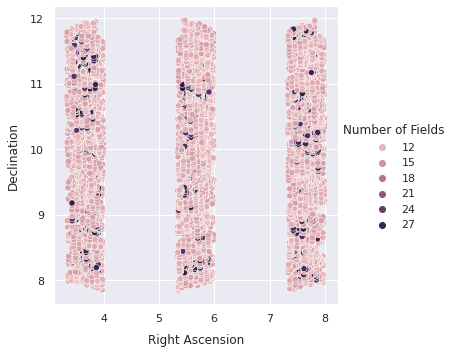

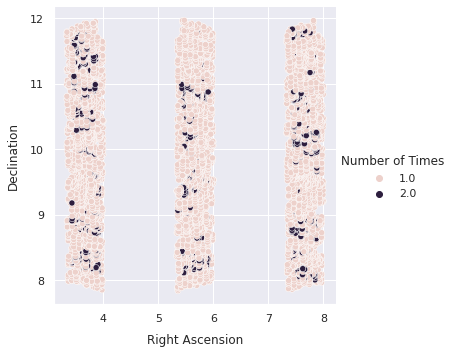

In [108]:
sns.set_theme()
g = sns.relplot(data=number_of_fovs[0:-1], x="Right Ascension", y="Declination", hue = "Number of Fields") 

g.set_axis_labels("Right Ascension", "Declination", labelpad=10)
g.figure.set_size_inches(6.5, 5)

h = sns.relplot(data=number_of_fovs[0:-1], x="Right Ascension", y="Declination", hue = "Number of Times") 

h.set_axis_labels("Right Ascension", "Declination", labelpad=10)
h.figure.set_size_inches(6.5, 5)

These are a few figures that I made to also try to better understand what is going on. This one looks at how the hits in each beam for the sample field of view are distributed. It shows the power on the y-axis, frequency on the x-axis, and the is color-coded by the SNR. So the highest power hits have the highest SNR, which makes sense. 

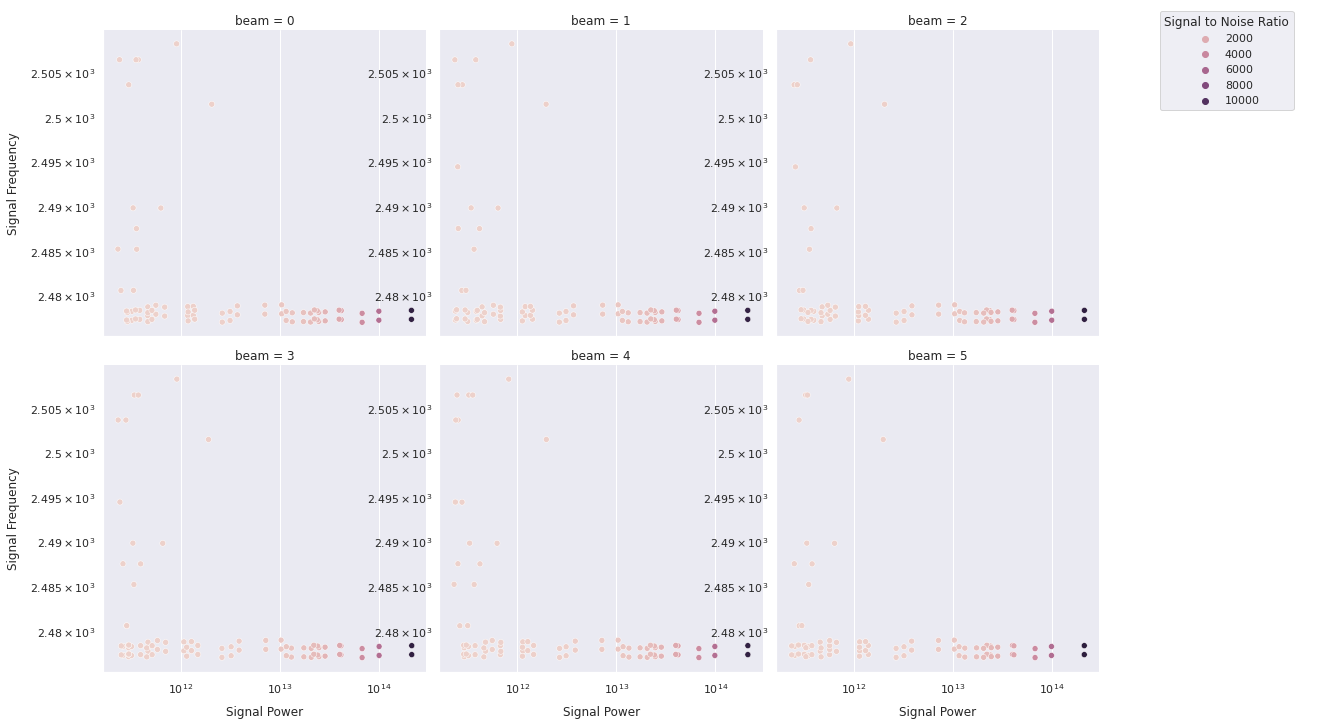

In [60]:
sns.set_theme()

g = sns.relplot(data=field_of_view_1, x="signal_power", y="signal_frequency", col="beam", hue="signal_snr", col_wrap = 3) 
g.set(xscale="log", yscale="log")

g.set_axis_labels("Signal Power", "Signal Frequency", labelpad=10)
g.legend.set_title("Signal to Noise Ratio")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

This figure then shows where each of the beams are inside of the field of view and with respect to each other. COSMIC selects the 5 nearest known stars from Gaia. Then beam 5 - the incoherent beam loses a lot of the spatial sensitivity because it just collects all of the photons from the entire field of view.

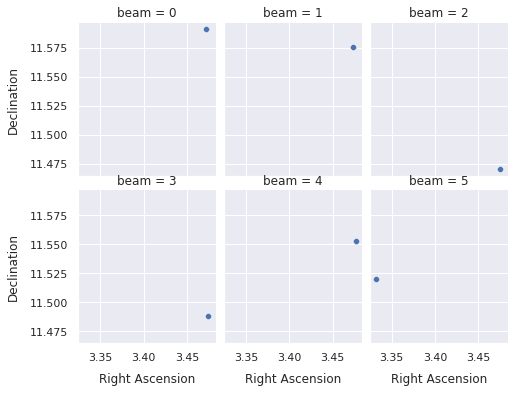

In [62]:
sns.set_theme()
g = sns.relplot(data=field_of_view_1, x="ra", y="dec", col="beam", col_wrap = 3) 

g.set_axis_labels("Right Ascension", "Declination", labelpad=10)
g.figure.set_size_inches(6.5, 5)

And then the last figure that I made here is showing the frequencies of the hits plotted across the observational area. This is a little deceptive because most of the sources have hits spanning the entire observed frequency range but in this plot because there are so many hits at each source, only the last hit is visible in the plot.

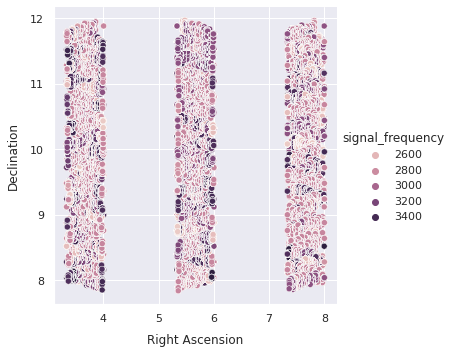

In [64]:
sns.set_theme()
g = sns.relplot(data=df, x="ra", y="dec", hue = 'signal_frequency') 

g.set_axis_labels("Right Ascension", "Declination", labelpad=10)
g.figure.set_size_inches(6.5, 5)